# Beyond Metropolis: some state-of-the-art MCMC algorithms

Back in notebook 4 we looked at the Metropolis algorithm, which is the basic building block of MCMC. It is *guaranteed* to converge on the target distribution, but we know that convergence will be *more efficient* if the **jump** (or **proposal**) distribution is similar to the target. This motivates the development of **adaptive** algorithms, where the proposal distribution is "tuned" as the Markov chain progresses.

There are lots of ways of implemeting adaptation (as well as various other innovations for improving the sampling efficiency), but a detailed description of modern MCMC algorithms is beyond the scope of these notes. What's more, if you're a hydrologist or an ecologist (rather than a statistician), you're probably more interested in *applying* MCMC, than learning about all the mathematical details. Fortunately, if you understand the principles of the Metropolis algorithm (see notebook 4), you should be in a good position to use some more sophisticated MCMC packages without having to worry too much about the algorithms themselves.

In this notebook, we'll start off by introducing two Python packages that implement a variety of state-of-the-art MCMC algorithms. We'll then use one of the packages to calibrate the hydrological model that we developed in notebook 5.

**Note for anyone using this notebook "interactively"**: If you've downloaded this notebook and are intending to run it on your local machine, please note that some of the MCMC code cells may take a long time to run (~30 minutes on my old desktop machine). 

## 1. Useful Python packages

### 1.1. PyMC3

**[PyMC3]('https://github.com/pymc-devs/pymc3')** is a Python package offering a variety of sophisticated MCMC samplers, including **Hamiltonian Monte Carlo (HMC)** and the **No U-Turn Sampler (NUTS)**. It also provides a very clean syntax for model specification (defining priors, likelihoods etc.), as well as convenience functions for a wide range of distributions. This makes setting up a model and running MCMC very simple: as an illustration, check out the **linear regression** example in the [PyMC3 tutorial]('http://pymc-devs.github.io/pymc3/getting_started/'). This is very similar to the example covered in notebook 4, except there we coded everything from scratch and used only a basic Metropolis algorithm. With PyMC3, the number of lines of code is dramatically reduced and we have the added advantage of being able to switch easily between several modern samplers.

However, a key property of the HMC and NUTS algorithms is they use the **gradient** of the target function to help tune the proposal distribution. This gives excellent performance for high-dimensional problems, but requires the target function to be **differentiable**. Unfortunately, as we have already seen in notebook 3, for complex environmental models the likelihood function is often not well-behaved, so the posterior distribution is not differentiable and many of the advantages of the HMC and NUTS algorithms are lost.

### 1.2. emcee

**[emcee]('http://dan.iel.fm/emcee/current/')** is Python package which implements an **affine invariant MCMC ensemble sampler** (a more detailed description of the algorithm from the package authors is [here]('http://arxiv.org/abs/1202.3665')). This sampler uses **multiple chains** together with some clever mathematical "tricks" to tune the proposal distribution *without* requiring gradient information. This makes it ideal for the kinds of complex likelihoods commonly encountered in environmental modelling. Furthermore, although in high-dimensional parameter spaces the HMC or NUTS algorithms *may* be more efficient, the multiple chains used by emcee are easy to parallelise, which offers a significant performance advantage.

The downside of emcee is that, unlike PyMC3, there are no easy ways to specify your model: you have to write Python functions from scratch to represent your priors, likelihood and posterior. For simple models, this is not a major limitation, but for more complex likelihoods (e.g. more sophisticated error structures) the process can become time consuming.

[It is possible]('http://twiecki.github.io/blog/2013/09/23/emcee-pymc/') that the emcee algorithm will eventually be integrated into PyMC3, but in the meantime I recommend investigating both packages as they're useful in different situations. 

In this notebook we're going to use emcee.

## 2. Parallel processing

To make the most of emcee, we will use **[`IPython.parallel`](http://ipython.org/ipython-doc/dev/parallel/)** to write code that can utilise a user-specified number of cores/processors. The first step is to launch multiple Python processes from the Jupyter `Clusters` tab on the `Home` screen, as shown in the image below

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeQkt3dDMtaEk0UTQ" alt="Jupyter clusters tab" height="700" width=700> 

Once you've found the `Clusters` tab, set the `# of engines` equal to the number of cores or processors you have available and then click `Start`. This will create several new Python processes, which we can use to distribute the MCMC work.

Next, we set up our IPython notebook to make use of these extra processes. The `view` object in the code below will allow us to allocate our jobs.

In [1]:
from IPython import parallel
c = parallel.Client()
view = c.load_balanced_view()

Each process has it's own namespace, so in order to run our MCMC, each process will need access to all the data necessary to evaluate our log posterior function. There are several ways to ensure this, but one of the simplest is to use IPython's `%%px --local` magic operator. As described in more detail [here](http://twiecki.github.io/blog/2014/02/24/ipython-nb-cluster/), placing this at the start of a notebook code cell will execute the same code on **all** of the available processes (i.e. all of the processes created above under the `Cluster` tab, plus the main Python process hosting the current notebook). We can use this to make sure that each process has access to all the necessary modules, functions and variables.

In the sections below, I've reproduced the hydrological model code from the previous notebook, but with some minor modifications to remove unnecessary clutter. Please refer to notebook 5 if you need a reminder of where all this comes from. 

Note also that the code here could (and should) be streamlined *a lot* more to reduce the amount of processing required for each model evaluation. In any real-world application, performance tweaks at this stage are usually well worth doing, because ultimately the model may be run tens or even hundreds of thousands of times by the MCMC algorithm. It is therefore worth expending a bit of effort tidying up the code (and perhaps even optimising bits of it into e.g. Fortran or C?) because small gains here can make a big difference later on. In the code that appears below I *haven't* done this, because I want to maintain continuity with the ideas and code presented in the previous notebook.

### 2.1. Import modules 

In [2]:
%%px --local

import numpy as np, pandas as pd
from scipy.integrate import odeint

### 2.2. Read the input data

Each process needs it's own copy of `met_df`.

In [3]:
%%px --local

# Download Tarland data into a Pandas dataframe
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

### 2.3. Define the ODE system

This function is used by `scipy.integrate.odeint` to integrate the model equations for each time step.

In [4]:
%%px --local

def f(y, t, params):
    """ Define ODE system.
            y is list [V, S, G, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for S and G
    Vi = y[0]
    Si = y[1]
    Gi = y[2]
    
    # Unpack params
    P, E, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    dS_dV = (((Vi - fc)*np.exp(fc - Vi))/(T_s*((np.exp(fc-Vi) + 1)**2))) + (1/(T_s*(np.exp(fc-Vi) + 1)))
    dV_dt = P - alpha*E*(1 - np.exp(-0.02*Vi)) - Si
    dS_dt = dS_dV*dV_dt
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    # Add results of equations to an array
    res = np.array([dV_dt, dS_dt, dG_dt, dDs_dt, dDg_dt])
    
    return res

### 2.4. Define the hydrological model

This function wraps the model equations in a loop to evaluate the drainage volume at each time step.

In [5]:
%%px --local

def simple_hydro_model(met_df, ics, mod_params, period, step_len=1):
    """ Runs the hydrological model.
    
            met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            mod_params     Vector of params [alpha, beta, T_s, T_g, fc]
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)
        
        Returns a dataframe with column headings
        
            [Vs, S, G, Ds, Dg, Sim_Runoff, Obs_Runoff]
    """
    # Truncate the met data to the desired period
    input_df = met_df.truncate(before=period[0], after=period[1])

    # Unpack initial conditions
    Vs0, Vg0 = ics
    
    # Unpack model parameters
    alpha, beta, T_s, T_g, fc = mod_params
    
    # Time points to evaluate ODEs at. We're only interested in the start and the end of each step
    ti = [0, step_len]

    # List to store output
    output = []

    # Loop over met data
    for idx in range(len(input_df)):
        # Get P and E for this day
        P = input_df.ix[idx, 'Rainfall_mm']
        E = input_df.ix[idx, 'PET_mm']

        # Calculate S0 and G0 from Vs0 and Vg0
        S0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
        G0 = Vg0/T_g 

        # Vector of initial conditions
        y0 = [Vs0, S0, G0, 0, 0]

        # Model parameters
        params=[P, E, alpha, beta, T_s, T_g, fc]

        # Solve
        y = odeint(f, y0, ti, args=(params,))

        # Extract values for end of step
        res = y[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        Vg0 = res[2]*T_g

    # Build a dataframe of results
    df = pd.DataFrame(data=np.vstack(output),
                      columns=['Vs', 'S', 'G', 'Ds', 'Dg'],
                      index=input_df.index)

    # Estimate runoff as Ds + Dg
    df['Sim_Runoff_mm'] = df['Ds'] + df['Dg']

    # Add observed runoff to df
    df['Obs_Runoff_mm'] = input_df['Runoff_mm']

    return df

### 2.5. Define log likelihood

The likelihood distribution that we will use initially is virtually identical to that defined in section 7.3 of notebook 4. To formulate the log-likelihood, we need to consider the relationship between **deterministic** and **stochastic** components in our overall model structure.

We already have the deterministic component of our model - it's just the function `simple_hydro_model` from above. For the stochastic component, we need to think about the expected error structure between our model's output and the observations. We'll start off by assuming **independent and identically distributed Gaussian errors**, exactly as we did in notebook 4. However, because we're dealing with time series data, we know that these assumptions are unlikely to be correct. In particular, based on the plot of simulated and observed runoff at the end of notebook 5, we might expect the errors to be autocorrelated, because they seem to be especially large during storm events and then become steadily smaller as flows decrease. We will therefore need to check our assumptions carefully and be willing to revise them if they are not met.

In [6]:
%%px --local

def log_likelihood(mcmc_params, met_df):
    """ mcmc_params    Vector of parameters [alpha, T_s, T_g, sigma_e]
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        
        Returns the log likelihood.
    """   
    # Extract calibrating parameter values
    alpha, T_s, T_g, sigma_e = mcmc_params
    
    # Run deterministic model with these parameters
    df = simple_hydro_model(met_df=met_df,
                            ics=[0, 0], # Assume ics at start of model run are always 0
                            mod_params=[alpha, beta, T_s, T_g, fc],
                            period=[st_dt, end_dt])
    
    # Discard the first year of simulations
    df = df.truncate(before='2001-01-01')    
    
    # Extract arrays for simulated and observed runoff
    sim = df['Sim_Runoff_mm']
    obs = df['Obs_Runoff_mm']
    n = len(df) # Length of dataset
    
    # Calculate log likelihood (see Section 2 of notebook 2 for explanation)
    ll = -n*np.log(2*np.pi*sigma_e**2)/2 - np.sum(((obs - sim)**2)/(2*sigma_e**2))
    
    return ll

### 2.6. Define log prior

We must define prior distributions for those model parameters we intend to calibrate (plus the standard deviation of the error term, $\sigma_\epsilon$; see notebook 4 for a reminder). The model parameters of interest are $\alpha$, $\tau_s$ and $\tau_g$ and, for the sake of simplicity, we will assume **uniform distributions** for all of these.

All of the parameters must be positive, so the minimum value for each is zero. We will define constants e.g. `alpha_max` to represent the upper limit for each parameter.

$\alpha$ is a correction factor applied to the PET data, which must be positive. We also know from notebook 5 that the PET estimates are likely to be high, so we expect $\alpha$ to be less than about 1. It certainly should not be any larger than 2, so we will set that as the upper limit

$$\alpha \sim \mathcal{U}(0, 2)$$

$\tau_s$ and $\tau_g$ are both poorly constrained, so we will set fairly wider priors on those

$$\tau_s \sim \mathcal{U}(0, 100) \qquad and \qquad \tau_g \sim \mathcal{U}(0, 1000)$$

Finally, we will initially assume that $\sigma_\epsilon$ lies between 0 and 5. This is somewhat arbitrary, but 5 is quite a large value for the error standard deviation and we might hope that the most likely value for $\sigma_\epsilon$ should be less than this. If this looks not to be the case, we can always return and modify our assumptions.

$$\sigma_\epsilon \sim \mathcal{U}(0, 5)$$

In [7]:
%%px --local

def log_prior(mcmc_params):
    """ mcmc_params is the vector of parameters [alpha, T_s, T_g, sigma_e]
    
        Returns the log prior probability of p
    """
    # Extract calibrating parameter values
    alpha, T_s, T_g, sigma_e = mcmc_params
    
    # If all parameters are within allowed ranges, return a constant 
    # (anything will do - I've used 0 here)
    if ((0 <= alpha < alpha_max) and (0 <= T_s < T_s_max) and 
        (0 <= T_g < T_g_max) and (0 <= sigma_e < sigma_e_max)):
        return 0
    # Else the parameter set is invalid (probability = 0; log prob = -inf)
    else:
        return -np.inf

### 2.7. Define log posterior

The **log posterior distribution** is (proportional to) the sum of the log prior and the log likelihood. The code below is almost identical to that used in Section 7.5 of notebook 4.

In [8]:
%%px --local

def log_posterior(mcmc_params, met_df):
    """ mcmc_params    Vector of parameters [alpha, T_s, T_g, sigma_e]
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        
        Returns the log posterior.
    """   
    # Get log prior prob
    log_pri = log_prior(mcmc_params)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(mcmc_params, met_df)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

### 2.8. Define fixed model parameters

Next we must define a range of constants needed by our model, including the date range of interest, the base flow index and the field capacity of the soil. We have already fixed these previously and we will use the same values here.

We must also set upper limits for the **uniform prior distributions** chosen for each of our calibrating parameters:

$\alpha$ is a correction factor applied to the PET data, which must be positive. We also know from notebook 5 that the PET estimates are likely to be too high, so we expect $\alpha$ to be less than about 1. It certainly should not be any larger than 2, so we will set that as the upper limit for now

$$\alpha \sim \mathcal{U}(0, 2)$$

$\tau_s$ and $\tau_g$ are both poorly constrained, so we will set fairly wider priors on those

$$\tau_s \sim \mathcal{U}(0, 100) \qquad and \qquad \tau_g \sim \mathcal{U}(0, 1000)$$

Finally, we will initially assume that $\sigma_\epsilon$ lies between 0 and 5. This is somewhat arbitrary, but 5 is quite a large value for the error standard deviation and we might hope that the most likely value for $\sigma_\epsilon$ should be less than this. If this looks not to be the case, we can always return and modify our assumptions.

$$\sigma_\epsilon \sim \mathcal{U}(0, 5)$$

In [9]:
%%px --local

# Fixed model parameters
beta = 0.6            # BFI (dimensionless)
fc = 290              # Field capacity (mm)
st_dt = '2000-01-01'  # Start date
end_dt = '2004-12-31' # End date

# Define upper limits for uniform priors
alpha_max = 2
T_s_max = 100
T_g_max = 1000
sigma_e_max = 5

### 2.9. Sample from the posterior using emcee

Up to this point, the steps above have been almost identical to those involved in the linear regression example from notebook 4. In that example, we used our own implementation of the Metropolis algorithm to do the sampling, but here we'll use something a bit more sophisticated - **emcee**.

As noted above, [emcee](http://dan.iel.fm/emcee/current/) uses a state-of-the-art MCMC algorithm which makes use of multiple chains (also called "**walkers**"). These walkers are the equivalent of the "*drunken mountaineers with walkie-talkies*" in the dodgy analogy from section 6 of notebook 4.

Note that for a real problem it might also be sensible to use an optimisier to estimate the **[Maximum a Posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)** density, just as we did in section 7.7 of notebook 4. This would allow us to generate random starting locations for each of our walkers in the vicinity of the MAP, which often improves the chances of efficient convergence. However, in this example we are instead going to start our walkers from locations selected randomly and unifromly from the joint prior distribution of our parameters. This will hopefully give up the opportunity to see them "homing-in" on the posterior distribution.

Note also that the code in the cell below *does not* need the `%%px --local` magic operator. emcee will handle distributing the MCMC chains to our "worker" processes, and the previous cells have already ensured that each process has all of the additional information required to run the model.



Average acceptance fraction:  0.47525
Autocorrelation time:  [ 37.85975923  48.42181938  29.2662363   43.99814025]


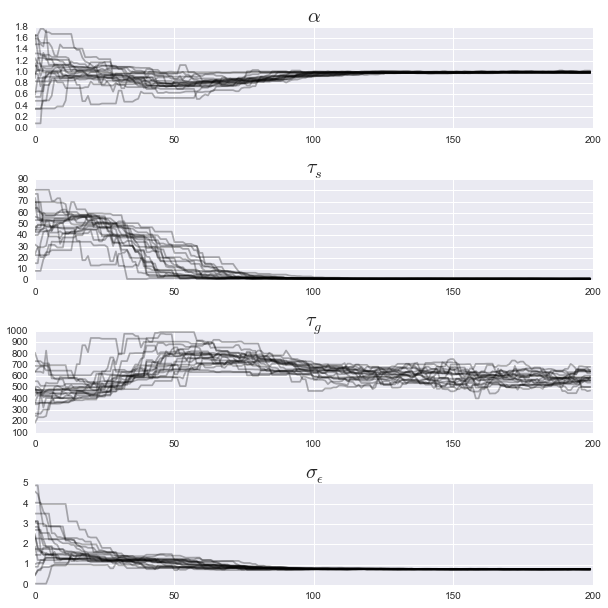

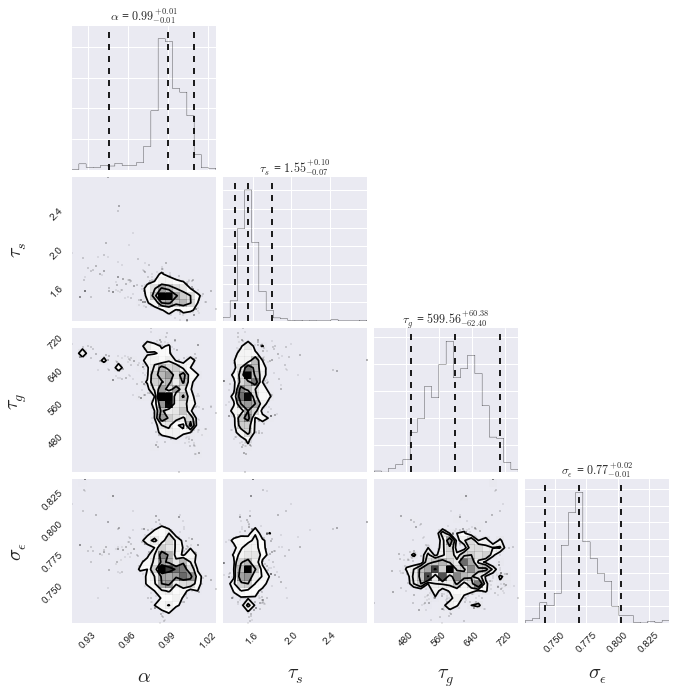

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
sn.set_context('notebook')

# emcee parameters
n_dim = 4      # Number of parameters being calibrated
n_walk = 20    # Number of "walkers"/chains
n_steps = 200  # Number of steps per chain
n_burn = 100   # Length of burn-in to discard

# Generate starting locations for the chains. These are just random
# points distributed uniformly across the 4D prior parameter space
starting_guesses = np.random.rand(n_walk, n_dim)
starting_guesses[:, 0] *= alpha_max    # Start alpha between 0 and alpha_max
starting_guesses[:, 1] *= T_s_max      # Start T_s between 0 and T_s_max
starting_guesses[:, 2] *= T_g_max      # Start T_g between 0 and T_g_max
starting_guesses[:, 3] *= sigma_e_max  # Start sigma_e between 0 and sigma_e_max

# Prepare to sample. The params are automatically passed to log_posterior
# as part of n_dim. "args" lists the other params that are also necessary
# Note the poo=view argument, which tells emcee how to interface with our
# "worker" processes
sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, 
                                pool=view, args=[met_df,])

# Run sampler
pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)

# Print some stats. based on run properties
print '\n'
print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
print 'Autocorrelation time: ', sampler.acor

# Get results
# Plot traces, including burn-in
param_labels = [r'$\alpha$', r'$\tau_s$', r'$\tau_g$', r'$\sigma_\epsilon$']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))    
for idx, title in enumerate(param_labels):        
    axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
    axes[idx].set_title(title, fontsize=20) 
plt.subplots_adjust(hspace=0.5)    
plt.show()

# Discard burn-in
samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

# Triangle plot
tri = corner.corner(samples,
                    labels=param_labels,
                    quantiles=[0.025, 0.5, 0.975],
                    show_titles=True, 
                    title_args={'fontsize': 24},
                    label_kwargs={'fontsize': 20})

## 3. Evaluating the results

Looking at the plots above, we can see the MCMC chains all seem to have converged successfully. What's more, the **marginal posterior densities** (the histograms along the diagonal of the bottom plot) are all well defined within the ranges specified by our priors, which is another good sign. If, on the other hand, we had chosen a range for one of our priors that was too narrow (e.g. by setting $T_{g}^{max} = 100$), then we might expect to see a strongly **left-skewed** marginal posterior, with most of the probability mass pressed up against the upper limit of the allowed range. This is quite common, and it's often an indication that you should repeat the MCMC using broader priors, but it's not an issue in the example here. In fact, the posterior distributions are all rather narrow and clearly **non-uniform**, indicating that the observed data contains enough information to place constraints on our model parameters.

By drawing parameter sets from our marginal posteriors and using them to run the model, we can can get an indication of the **parameter-related uncertainty** in our model output. In the code below, we first draw 100 parameter sets at random from our MCMC chains (after discarding the burn-in). For each of these parameter sets we'll run the model and we'll then plot the median model simulation plus the 95% credible interval around it.

Note that in the code below I've used the excellent **[mpld3 library](http://mpld3.github.io/)** to create the plot, so you should be able to click the magnifying glass near the bottom left corner and zoom in to see the uncertainty bounds on the simulated curve.

In [13]:
# Set fixed model parameters
beta = 0.6            # BFI (dimensionless)
fc = 290              # Field capacity (mm)
st_dt = '2000-01-01'  # Start date
end_dt = '2004-12-31' # End date

# Number of param sets to use
n_sets = 500

# Store output data in list
output = []

# Pick 100 parameter sets at random from the converged chains
for alpha, T_s, T_g, sigma_e in samples[np.random.randint(len(samples), size=n_sets)]:
    # Initial conditions
    Vs0 = 0.       # Initial soil volume (mm)
    Vg0 = 0.       # Initial groundwater volume (mm)

    # Run model
    df = simple_hydro_model(met_df=met_df,
                            ics=[Vs0, Vg0],
                            mod_params=[alpha, beta, T_s, T_g, fc],
                            period=[st_dt, end_dt])

    # Discard burn-in
    df = df.truncate(before='2001-01-01')
    
    # Add to output
    output.append(df[['Sim_Runoff_mm']])
    
# Concatenate results into single df
df = pd.concat(output, axis=1)

# Get 2.5, 50 and 97.5 percentiles for plotting
df = df.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]

# Get observations
obs = met_df[['Runoff_mm']].truncate(before='2001-01-01', after=end_dt)

# Plot
fig = plt.figure()
plt.fill_between(df.index, df['2.5%'], df['97.5%'], alpha=0.3)
plt.plot(obs.index, obs['Runoff_mm'], label='Observed')
plt.plot(df.index, df['50%'], label='Simulated')
plt.legend(loc='best')
mpld3.display()

Looking at this plot, the median simulated curve does not compare terribly well to the observed data. Although most of the major flow peaks are simulated, the median recession time is too fast, meaning that the model returns very rapidly to baseflow conditions following rainfall events. In addition, the very long groundwater residence time ($T_g = 600 \; days$) gives an almost constant baseflow during dry periods, which does not accutaely reflt the lowest discharges observed. In addition, there are several minor peaks in the observed data that are not present in our simulated flow series, and vice versa. Some of these problems are almost certainly due to issues with our input data, which we won't delve into here because we explicitly decided not to consider them at the start of the analysis. However, it's worth considering some features of this plot in a bit more detail. 